In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

## Eigen Face
from sklearn.decomposition import PCA 

import pickle

In [2]:
# Load the data
data = pickle.load(open('./FEA_data/expression_data_images_100_100.pickle',mode='rb')) # load the data

In [3]:
data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_9991,pixel_9992,pixel_9993,pixel_9994,pixel_9995,pixel_9996,pixel_9997,pixel_9998,pixel_9999,expression
0,0.031373,0.078431,0.086275,0.043137,0.262745,0.192157,0.172549,0.223529,0.309804,0.219608,...,0.647059,0.619608,0.584314,0.564706,0.603922,0.631373,0.596078,0.580392,0.580392,happy
1,0.568627,0.564706,0.568627,0.560784,0.560784,0.552941,0.521569,0.486275,0.262745,0.164706,...,0.023529,0.019608,0.023529,0.039216,0.074510,0.109804,0.074510,0.078431,0.086275,happy
2,0.101961,0.023529,0.054902,0.043137,0.054902,0.047059,0.074510,0.078431,0.074510,0.125490,...,0.827451,0.831373,0.831373,0.831373,0.835294,0.823529,0.827451,0.823529,0.807843,happy
3,0.427451,0.443137,0.447059,0.443137,0.435294,0.431373,0.400000,0.317647,0.215686,0.207843,...,0.231373,0.180392,0.188235,0.200000,0.192157,0.200000,0.184314,0.180392,0.180392,happy
4,0.066667,0.050980,0.066667,0.086275,0.125490,0.129412,0.129412,0.086275,0.035294,0.015686,...,0.627451,0.619608,0.560784,0.572549,0.572549,0.560784,0.549020,0.564706,0.427451,happy


##### Eigen Face

In [4]:
# Mean Face
X = data.drop('expression',axis=1).values # all images

In [5]:
X

array([[0.03137255, 0.07843137, 0.08627451, ..., 0.59607843, 0.58039216,
        0.58039216],
       [0.56862745, 0.56470588, 0.56862745, ..., 0.0745098 , 0.07843137,
        0.08627451],
       [0.10196078, 0.02352941, 0.05490196, ..., 0.82745098, 0.82352941,
        0.80784314],
       ...,
       [0.68627451, 0.65098039, 0.59215686, ..., 0.88235294, 0.85098039,
        0.86666667],
       [0.57647059, 0.59607843, 0.6       , ..., 0.40784314, 0.48235294,
        0.55686275],
       [0.16862745, 0.1254902 , 0.14117647, ..., 0.16078431, 0.16862745,
        0.14901961]])

In [6]:
y = data['expression'].values

# balancing the dataset

In [7]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

def balance_dataset(X, y, method='oversample'):
    if method == 'oversample':
        sampler = RandomOverSampler()
    elif method == 'undersample':
        sampler = RandomUnderSampler()
    else:
        raise ValueError("Invalid method. Choose either 'oversample' or 'undersample'.")
    
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    return X_resampled, y_resampled


X, y = balance_dataset(X, y, method='oversample')



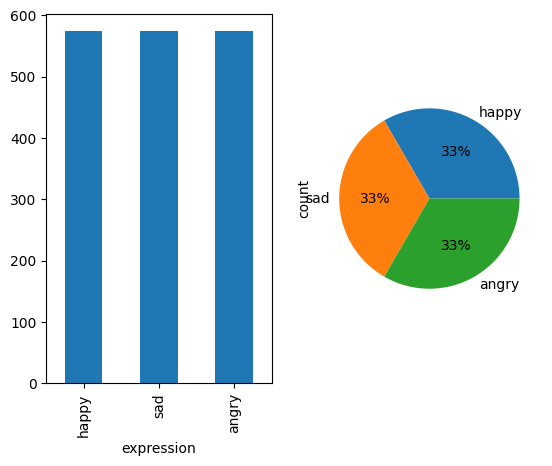

In [8]:
dist_expression = pd.DataFrame(y,columns=['expression']).expression.value_counts()
fig,ax = plt.subplots(nrows=1,ncols=2)
dist_expression.plot(kind='bar',ax=ax[0])
dist_expression.plot(kind='pie',ax=ax[1],autopct='%0.0f%%')
plt.show()

In [9]:
mean_face = X.mean(axis=0) # flatten mean face
mean_face.shape

(10000,)

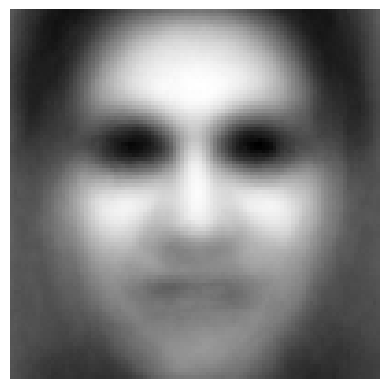

In [10]:
# visualize mean face
plt.imshow(mean_face.reshape((100,100)),cmap='gray')
plt.axis('off')
plt.show()

**Subtract data with mean face**

In [11]:
X_t = X - mean_face # transformed data

In [12]:
pca = PCA(n_components=None,whiten=True,svd_solver='auto')
pca.fit(X_t)

PCA(whiten=True)

In [13]:
exp_var_df = pd.DataFrame()
exp_var_df['explained_var'] = pca.explained_variance_ratio_
exp_var_df['cum_explained_var'] = exp_var_df['explained_var'].cumsum()
exp_var_df['principal_components'] = np.arange(1,len(exp_var_df)+1)

exp_var_df.head()

,explained_var,cum_explained_var,principal_components
0,0.286689,0.286689,1
1,0.096258,0.382948,2
2,0.091140,0.474087,3
3,0.049944,0.524032,4
4,0.046870,0.570901,5


In [14]:
exp_var_df.set_index('principal_components',inplace=True)

<Axes: xlabel='principal_components'>

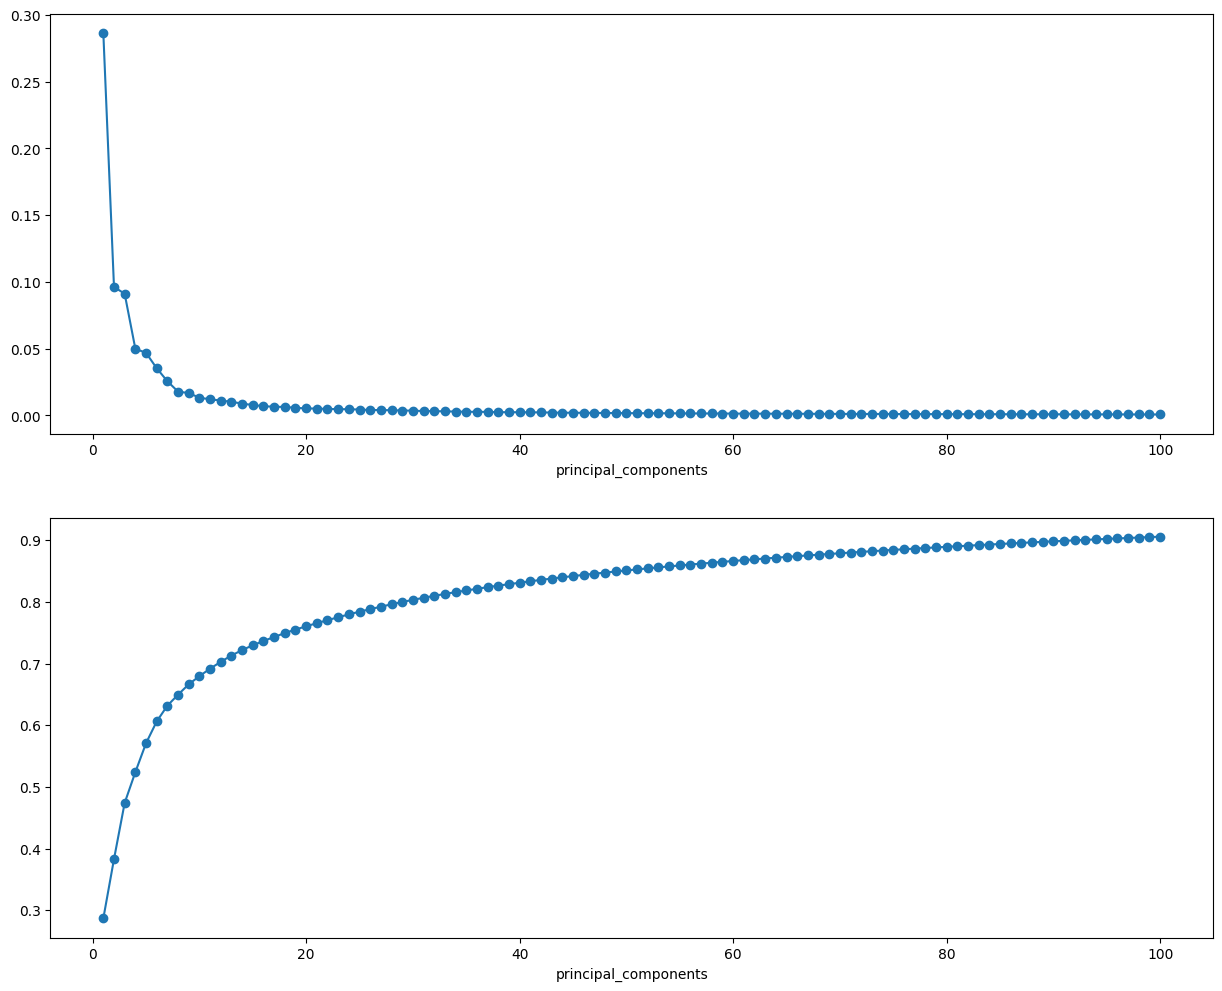

In [15]:
# visualize explained variance
fig, ax = plt.subplots(nrows=2,figsize=(15,12))

exp_var_df['explained_var'].head(100).plot(kind='line',marker='o',ax=ax[0])
exp_var_df['cum_explained_var'].head(100).plot(kind='line',marker='o',ax=ax[1])

From above plot, it is clear that with approximately **50 pricipal components having 80%** converage.

In [26]:
pca_50 = PCA(n_components=50,whiten=True,svd_solver='auto')
pca_data = pca_50.fit_transform(X_t)

In [27]:
pca_data.shape

(1722, 50)

In [28]:
np.savez('./FEA_data/expression_data_pca_50_target',pca_data,y)

In [29]:
# saving the model
pca_dict = {'pca':pca_50,'mean_face':mean_face}

In [30]:
pickle.dump(pca_dict,open('FEA_model/pca_dict.pickle','wb'))

### Visualize Eigen Image

In [31]:
pca_data_inv = pca_50.inverse_transform(pca_data)

In [32]:
pca_data_inv.shape

(1722, 10000)

In [33]:
eig_img = pca_data_inv[0,:].reshape((100,100))
eig_img.shape

(100, 100)

(-0.5, 99.5, 99.5, -0.5)

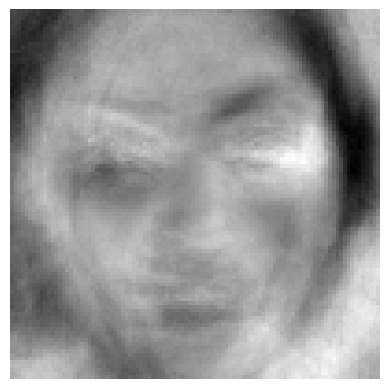

In [34]:
plt.imshow(eig_img,cmap='gray')
plt.axis('off')

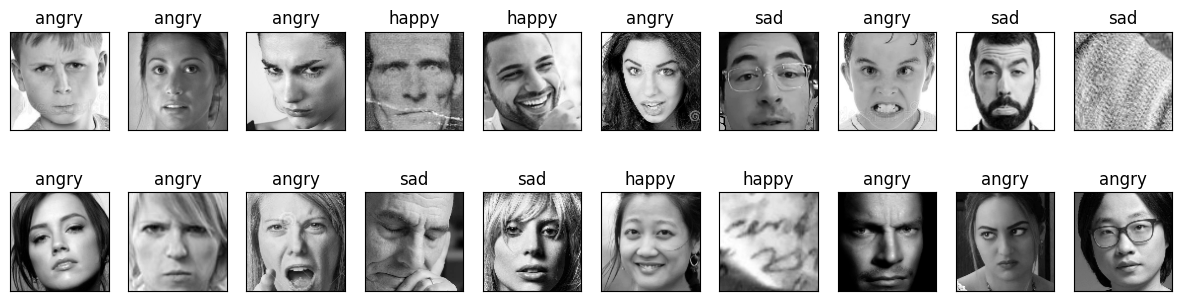

====================Eigen Images====================


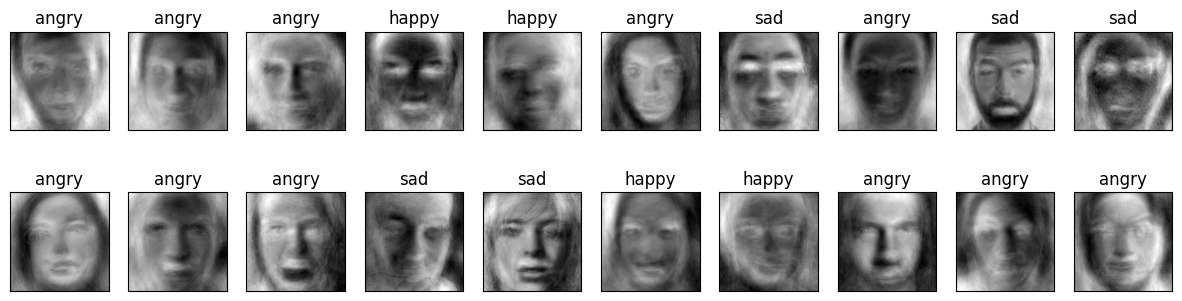

In [41]:
np.random.seed(1001)
pics = np.random.randint(0,1519,20)
plt.figure(figsize=(15,8))
for i,pic in enumerate(pics):
    plt.subplot(4,10,i+1)
    img = X[pic:pic+1].reshape(100,100)
    plt.imshow(img,cmap='gray')
    plt.title('{}'.format(y[pic]))
    plt.xticks([])
    plt.yticks([])
plt.show()

print("="*20+'Eigen Images'+"="*20)
plt.figure(figsize=(15,8))
for i,pic in enumerate(pics):
    plt.subplot(4,10,i+1)
    img = pca_data_inv[pic:pic+1].reshape(100,100)
    plt.imshow(img,cmap='gray')
    plt.title('{}'.format(y[pic]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()